In [91]:
import pandas as pd
target = pd.read_csv("./training_set_labels.csv", index_col=0)
target.shape

(26707, 2)

In [92]:
# Features
features = pd.read_csv("./training_set_features.csv", index_col=0)
features.shape

(26707, 35)

In [93]:
# this is for submission
test_set_features = pd.read_csv("./test_set_features.csv", index_col=0)
test_set_features.shape

(26708, 35)

In [94]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [95]:
# Searching for null values.
features.isna().sum() 

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

In [96]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler())
    ])
# The constant on here is ZERO, as we will assume that missing values on 
# health_insurance are those who are not covered.
hardcoded_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant")),
        ("scaler", StandardScaler())
    ])
non_weight_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])
# Indicating to pipeline replace those null values with
# the most frequent value found in that specific row.
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OrdinalEncoder()),
    ])

num_attribs = ["h1n1_concern", "h1n1_knowledge", "behavioral_antiviral_meds", "behavioral_avoidance", "behavioral_face_mask","behavioral_wash_hands","behavioral_large_gatherings", "behavioral_outside_home", "behavioral_touch_face", "doctor_recc_h1n1", "doctor_recc_seasonal", "chronic_med_condition", "child_under_6_months", "health_worker", "opinion_h1n1_vacc_effective", "opinion_h1n1_risk", "opinion_h1n1_sick_from_vacc", "opinion_seas_vacc_effective", "opinion_seas_risk", "opinion_seas_sick_from_vacc"]
hardcoded_attribs = ["health_insurance"]
non_weight_attribs = ["race", "sex", "hhs_geo_region", "employment_industry", "employment_occupation"]
cat_attribs = ["age_group", "education", "income_poverty", "marital_status", "rent_or_own", "employment_status", "census_msa", "household_adults", "household_children"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("hardcoded", hardcoded_pipeline, hardcoded_attribs),
        ("non_weight", non_weight_pipeline, non_weight_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])
total_attribs = num_attribs + hardcoded_attribs + non_weight_attribs +cat_attribs
X_train = preprocess_pipeline.fit_transform(
    features[total_attribs])
y_train = target["h1n1_vaccine"]
y_train

respondent_id
0        0
1        0
2        0
3        0
4        0
        ..
26702    0
26703    0
26704    0
26705    0
26706    0
Name: h1n1_vaccine, Length: 26707, dtype: int64

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

# Please, check the variables applicable to next line:
logistic_clf = LogisticRegression(max_iter=2000)
logistic_clf.fit(X_train, y_train)

c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
# Instantiating the GridSearchCV object
logreg_cv = GridSearchCV(logistic_clf, param_grid, cv = 5)
logreg_cv.fit(X_train, y_train)
 
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.05179474679231213}
Best score is 0.8512892535421542


In [115]:
from sklearn.metrics import accuracy_score

y_pred = logreg_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8488705852988893

In [99]:
from sklearn.model_selection import cross_val_score


logistic_scores = cross_val_score(logistic_clf, X_train, y_train, cv=5)
logistic_scores.mean()

0.8511287828280596

In [100]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# X_train_transformed.shape
# model is for logistic
logistic_clf_y_pred = logistic_clf.predict(X_test)
logistic_clf_y_pred_proba = logistic_clf.predict_proba(X_test) #to calculate ROC_AUC, we need model.predict_proba() instead of model.pred()


print(f"accuracy_score: {accuracy_score(y_test, logistic_clf_y_pred)}")
print(f"precision_score: {precision_score(y_test, logistic_clf_y_pred)}")
print(f"recall_score: {recall_score(y_test, logistic_clf_y_pred)}")
print(f"f1_score: {f1_score(y_test, logistic_clf_y_pred)}")

accuracy_score: 0.847997004867091
precision_score: 0.7076788830715532
recall_score: 0.4787485242030697
f1_score: 0.5711267605633802


In [101]:
logistic_clf_y_pred_proba

array([[0.93265068, 0.06734932],
       [0.94426318, 0.05573682],
       [0.92893276, 0.07106724],
       ...,
       [0.99780004, 0.00219996],
       [0.98954141, 0.01045859],
       [0.91484995, 0.08515005]])

In [102]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf_X_test = preprocess_pipeline.transform(test_set_features[total_attribs])
forest_clf_y_pred = forest_clf.predict(X_test)

In [103]:
forest_clf_y_pred = forest_clf.predict(X_test)
forest_clf_y_pred_proba = forest_clf.predict_proba(X_test) #to calculate ROC_AUC, we need model.predict_proba() instead of model.pred()
print(f"accuracy_score: {accuracy_score(y_test, forest_clf_y_pred)}")
print(f"precision_score: {precision_score(y_test, forest_clf_y_pred)}")
print(f"recall_score: {recall_score(y_test, forest_clf_y_pred)}")
print(f"f1_score: {f1_score(y_test, forest_clf_y_pred)}")
# print(f"roc_auc_score: {roc_auc_score(y_test, y_pred_proba[:,1])}")

accuracy_score: 0.8464994384125796
precision_score: 0.7473347547974414
recall_score: 0.4138134592680047
f1_score: 0.5326747720364742


In [104]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=5)
forest_scores.mean()

0.8496308272054958

In [105]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=5)
svm_scores.mean()

0.8506474851646157

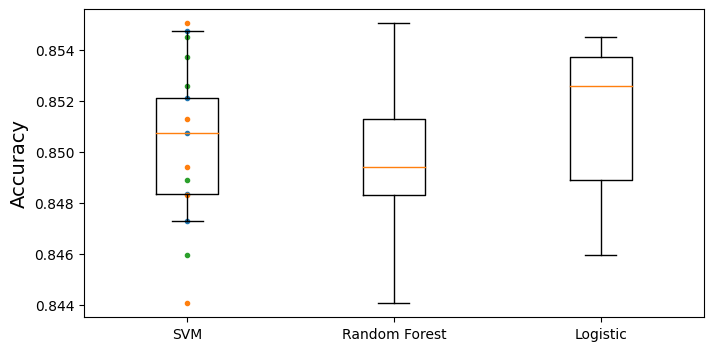

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*5, svm_scores, ".")
plt.plot([1]*5, forest_scores, ".")
plt.plot([1]*5, logistic_scores, ".")

plt.boxplot([svm_scores, forest_scores, logistic_scores], labels=("SVM","Random Forest", "Logistic"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [ ]:
import joblib

joblib.dump(my_model, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_model.pkl")